# Tutorial 11: Interpretation
___

In this tutorial we introduce the interpretation module, which provides various mechanisms for users to visualize / interpret what a neural network is seeing / focusing on within an input in order to make its decision. Since it will demonstrate bash commands which require certain path information, __this notebook should be run with the tutorial folder as the root directory__.

All interpretation modules may be invoked in three ways:   
    1) From the command line: fastestimator visualize COMMAND   
    2) From a python API: visualize_COMMAND()   
    3) From a __Trace__ which may then be combined with the __TensorBoard__ __Trace__ or any other image IO __Trace__

## Download a sample model for demonstration

In [1]:
import tensorflow as tf
import os

model = tf.keras.applications.InceptionV3(weights='imagenet')  # This will download a .h5 file to ~/.keras/models
os.makedirs('./outputs', exist_ok=True)
model.save('./outputs/inceptionV3.h5')

## Interpretation with Bash

We'll start by running the caricature interpretation via the command line. Depending on how you downloaded FastEstimator, you may need to run `python setup.py install` from the parent directory in order to invoke the fastestimator command. For the next few examples we'll be considering an image of a pirate ship: <div>&quot;<a href='https://www.flickr.com/photos/torley/3104607205/' target='_blank'>pirate ship by teepunch Jacobus</a>&quot;&nbsp;(<a rel='license' href='https://creativecommons.org/licenses/by-sa/2.0/' target='_blank'>CC BY-SA 2.0</a>)&nbsp;by&nbsp;<a xmlns:cc='http://creativecommons.org/ns#' rel='cc:attributionURL' property='cc:attributionName' href='https://www.flickr.com/people/torley/' target='_blank'>TORLEY</a></div>

In [2]:
!fastestimator visualize caricature ./outputs/inceptionV3.h5 ./image/pirates.jpg --layers 196 --dictionary ./image/imagenet_class_index.json --save ./outputs

2019-10-21 15:36:49.763167: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-10-21 15:36:49.774601: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd74c9c5d10 executing computations on platform Host. Devices:
2019-10-21 15:36:49.774621: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
Layer 196: 100%|██████████████████████████████| 250/250 [02:40<00:00,  1.77it/s]
Saving to ./outputs/caricatures.png


Now lets load the image generated from the bash command back into memory for visualization:

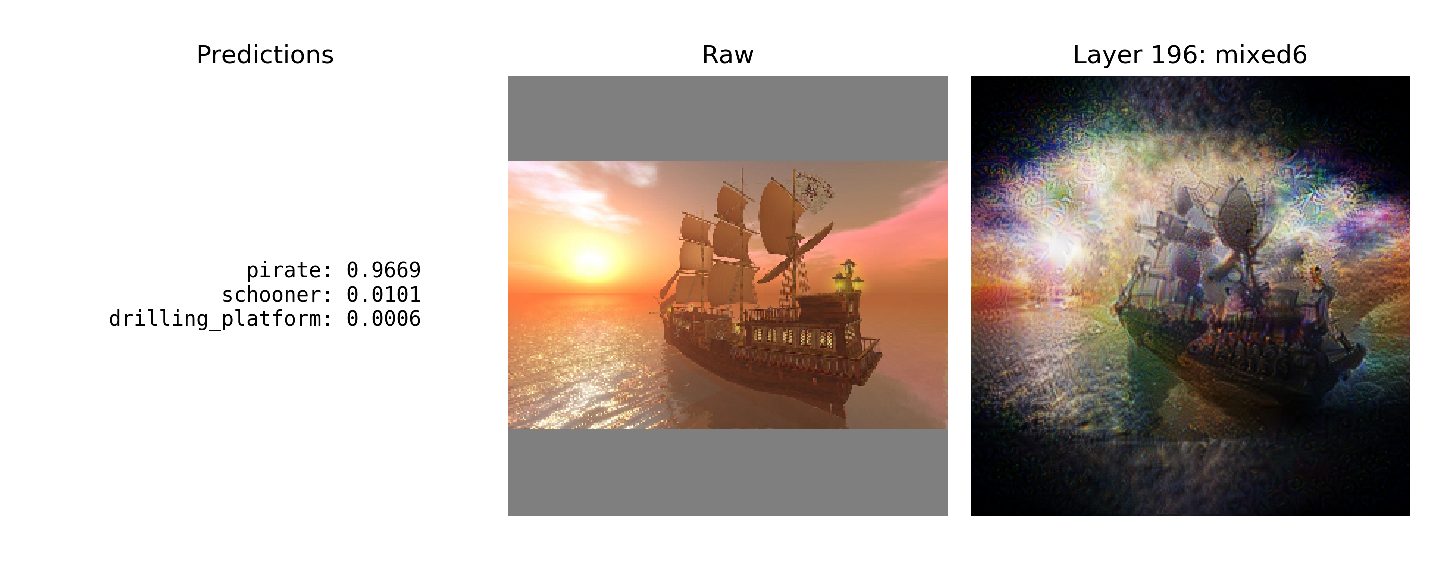

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from fastestimator.xai import show_image

%matplotlib inline

caricature = plt.imread('./outputs/caricatures.png')
mpl.rcParams['figure.dpi']=300
show_image(caricature)
plt.show()

A human who was trying to identify a pirate ship would likely focus on 2 key components: whether they are looking at a ship, and whether that ship is flying a pirate flag. From the caricature we can see that the stern of the ship is strongly emphasized, and that there is a large but ambiguously structured area for the sails. Interestingly, the pirate flag is completely absent from the caricature -- perhaps indicating the network is not interested in the flag. Our next interpretation module will investigate this more closesly. 

## Interpretation with Python API

Now lets run a saliency analysis (a different interpretation method), this time via the FastEstimator python API. We'll start by loading the pirate image into memory and sizing it appropriately

In [4]:
from fastestimator.util.util import load_dict, load_image

input_type = model.input.dtype
input_shape = model.input.shape
n_channels = 0 if len(input_shape) == 3 else input_shape[3]
input_height = input_shape[1]
input_width = input_shape[2]
inputs = [load_image('./image/pirates.jpg', channels=n_channels)]
tf_image = tf.stack([
    tf.image.resize_with_pad(tf.convert_to_tensor(im, dtype=input_type),
                             input_height,
                             input_width,
                             method='lanczos3') for im in inputs
])
pirates = tf.clip_by_value(tf_image, -1, 1)
dic = load_dict('./image/imagenet_class_index.json')
baseline = tf.zeros_like(pirates) + 0.5

Now lets run the FE saliency api:

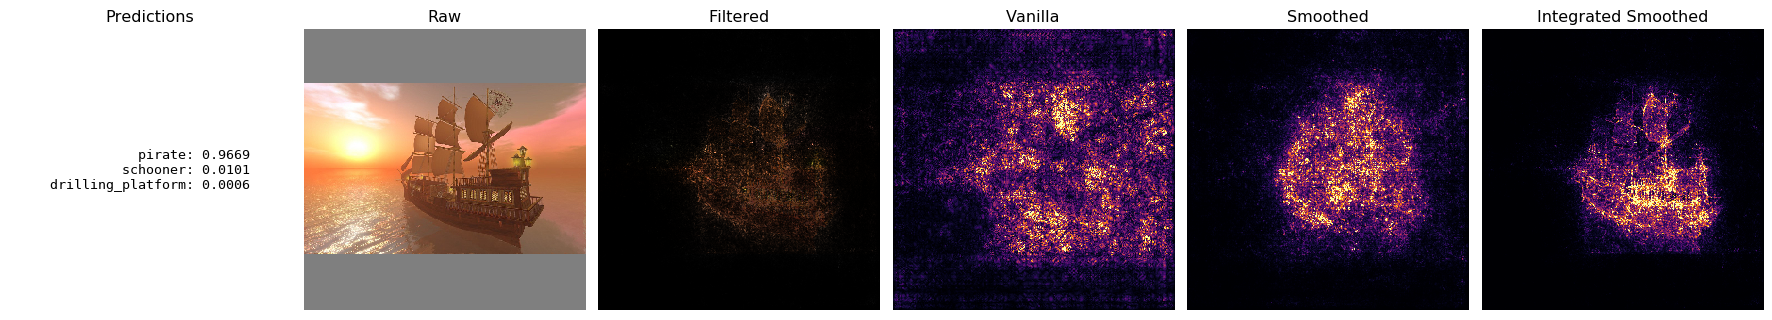

In [5]:
from fastestimator.xai import visualize_saliency

visualize_saliency(model, pirates, baseline_input=baseline, decode_dictionary=dic, save_path=None)

Here we can see that, as in the caricature analysis, there seems to be strong emphasis on the stern of the ship, with some focus on the sails, but none on the pirate flag. It seems likely that the neural network has not learned that pirates are regular boats with a flag modifier, but rather that it has correlated a certain stereotypical ship design with pirate ships. 

## Interpretation with Traces

We now move on to a discussion of interpretation with Traces. For this example we will switch to the CIFAR10 dataset and see how UMAPs can be used to visualize what a network 'knows' about different classes.

In [6]:
import tensorflow as tf
from tensorflow.python.keras import layers, Sequential, Model

from fastestimator import Pipeline, Network, build, Estimator
from fastestimator.architecture import LeNet
from fastestimator.op.tensorop import Minmax, ModelOp, SparseCategoricalCrossentropy
from tensorflow.python.keras import layers, Sequential
from fastestimator.trace import UMap, ConfusionMatrix, VisLogger


(x_train, y_train), (x_eval, y_eval) = tf.keras.datasets.cifar10.load_data()
data = {"train": {"x": x_train, "y": y_train}, "eval": {"x": x_eval, "y": y_eval}}
num_classes = 10
class_dictionary = {
    0: "airplane", 1: "car", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"
}

pipeline = Pipeline(batch_size=32, data=data, ops=Minmax(inputs="x", outputs="x"))

model = build(model_def=lambda: LeNet(input_shape=x_train.shape[1:], classes=num_classes),
              model_name="LeNet",
              optimizer="adam",
              loss_name="loss")

network = Network(ops=[
    ModelOp(inputs="x", model=model, outputs="y_pred"),
    SparseCategoricalCrossentropy(y_true="y", y_pred="y_pred", outputs="loss")
])

traces = [
    UMap(model_name="LeNet", model_input="x", labels="y", label_dictionary=class_dictionary),
    ConfusionMatrix("y", "y_pred", num_classes),
    VisLogger(show_images="LeNet_UMap")
]

estimator = Estimator(network=network, pipeline=pipeline, traces=traces, epochs=5, log_steps=750)


    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
FastEstimator-Start: step: 0; total_train_steps: 7810; LeNet_lr: 0.001; 
FastEstimator-Train: step: 0; loss: 2.3101635; 
FastEstimator-Train: step: 750; loss: 1.3519791; examples/sec: 1296.9; progress: 9.6%; 
FastEstimator-Train: step: 1500; loss: 1.3446811; examples/sec: 1302.1; progress: 19.2%; 
FastEstimator-Eval: step: 1562; epoch: 0; loss: 1.2924408; min_loss: 1.2924408; since_best_loss: 0; 
confusion_matrix:
[[373, 25,136, 22, 54, 33, 21, 22,250, 62],
 [ 20,586, 25, 16,  7, 

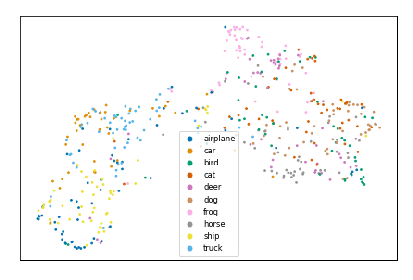

FastEstimator-Train: step: 2250; loss: 1.1463277; examples/sec: 1349.7; progress: 28.8%; 
FastEstimator-Train: step: 3000; loss: 1.1687264; examples/sec: 1338.1; progress: 38.4%; 
FastEstimator-Eval: step: 3124; epoch: 1; loss: 1.0939319; min_loss: 1.0939319; since_best_loss: 0; 
confusion_matrix:
[[571, 31, 77, 18, 22,  3,  6,  3,240, 27],
 [ 23,749,  8,  8,  5,  5,  6,  4,115, 75],
 [ 74,  8,565, 52,115, 58, 42, 11, 65, 10],
 [ 23, 17,158,352,104,183, 58, 15, 71, 17],
 [ 30, 12,152, 37,580, 34, 46, 67, 39,  3],
 [ 17,  5,168,136, 58,518, 21, 37, 31,  8],
 [ 11, 11, 95, 74, 78, 29,648, 10, 31, 10],
 [ 27,  6, 67, 32,129, 80,  6,598, 11, 43],
 [ 35, 27, 12, 11,  5,  4,  0,  0,889, 14],
 [ 33,131, 13,  7,  9,  5,  8,  6,123,663]];


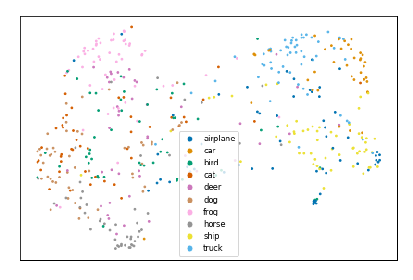

FastEstimator-Train: step: 3750; loss: 1.1247885; examples/sec: 1376.0; progress: 48.0%; 
FastEstimator-Train: step: 4500; loss: 1.1616662; examples/sec: 1347.8; progress: 57.6%; 
FastEstimator-Eval: step: 4686; epoch: 2; loss: 0.9925265; min_loss: 0.99252653; since_best_loss: 0; 
confusion_matrix:
[[711, 40, 72, 12, 23, 13, 11, 10, 49, 57],
 [ 24,869,  4,  9,  2,  7, 10,  2, 10, 62],
 [ 84, 10,481, 45, 61,180, 80, 26, 12, 20],
 [ 19, 24, 58,314, 60,374, 88, 27,  8, 25],
 [ 18, 16,103, 43,477,125,105, 94, 12,  7],
 [ 13, 13, 41, 87, 20,731, 31, 49,  5,  7],
 [  9, 15, 40, 51, 20, 73,772,  9,  3,  8],
 [ 19,  7, 18, 22, 58,148, 11,683,  2, 29],
 [116, 69, 23, 21,  7, 16,  7,  1,680, 57],
 [ 26,129,  9,  9,  6, 11, 11, 13, 17,769]];


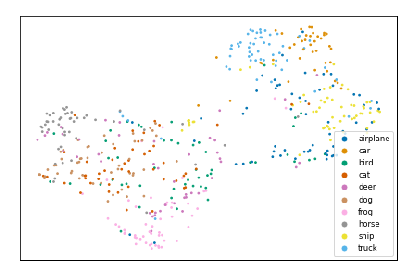

FastEstimator-Train: step: 5250; loss: 1.2001882; examples/sec: 1369.0; progress: 67.2%; 
FastEstimator-Train: step: 6000; loss: 0.9163003; examples/sec: 1356.9; progress: 76.8%; 
FastEstimator-Eval: step: 6248; epoch: 3; loss: 0.9043628; min_loss: 0.9043628; since_best_loss: 0; 
confusion_matrix:
[[653, 19,100, 11, 36,  4, 11, 18,102, 43],
 [ 14,772,  6,  6,  8,  4, 13,  8, 44,124],
 [ 43,  8,593, 51,124, 53, 59, 30, 22, 15],
 [ 11, 13,121,436,112,147, 81, 29, 23, 25],
 [ 15,  5, 75, 39,668, 19, 66, 86, 19,  6],
 [ 12,  6,101,144, 65,548, 43, 64,  9,  6],
 [  7,  9, 56, 61, 47, 10,786,  5, 12,  6],
 [ 11,  2, 49, 31, 66, 59, 10,735,  8, 27],
 [ 44, 34, 20, 13, 13,  4,  3,  5,832, 32],
 [ 24, 62, 11, 10, 10,  5, 12, 16, 36,813]];


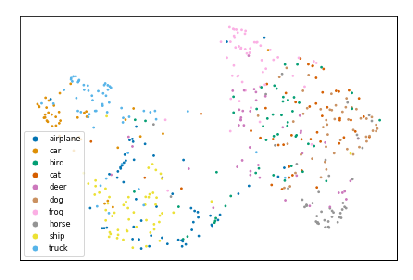

FastEstimator-Train: step: 6750; loss: 0.5382401; examples/sec: 1319.7; progress: 86.4%; 
FastEstimator-Train: step: 7500; loss: 1.0533242; examples/sec: 1323.5; progress: 96.0%; 
FastEstimator-Eval: step: 7810; epoch: 4; loss: 0.9195166; min_loss: 0.9043628; since_best_loss: 1; 
confusion_matrix:
[[740, 30, 45, 42, 13, 14,  4, 14, 58, 37],
 [ 14,850,  7, 14,  2,  5,  5,  2, 30, 71],
 [ 66,  6,550,151, 26,108, 31, 35, 14,  9],
 [ 12, 17, 46,538, 30,275, 22, 30, 11, 17],
 [ 16,  8,107,128,429,104, 39,151,  9,  8],
 [ 10,  6, 32,163, 14,701,  8, 54,  5,  6],
 [  5, 20, 46,157, 15, 90,641, 10,  6,  9],
 [ 16,  2, 25, 59, 14, 93,  3,765,  4, 18],
 [ 63, 39, 14, 42,  4,  7,  1,  2,793, 33],
 [ 23, 84,  5, 35,  1,  9,  4, 20, 33,785]];


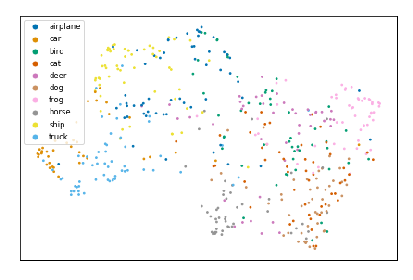

FastEstimator-Finish: step: 7810; total_time: 211.34 sec; LeNet_lr: 0.001; 


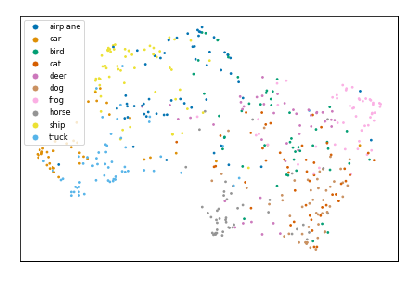

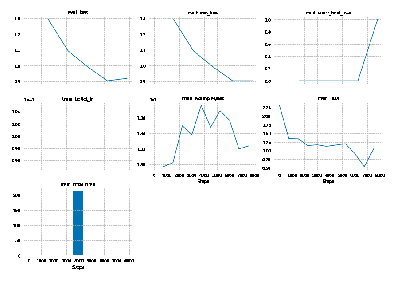

In [7]:
estimator.fit()

As the UMaps reveal, the network is learning to separate man-made objects from natural ones. It also becomes clear that classes like 'cars' and 'trucks' are more similar to one another than they are to 'airplaines'. This all lines up with human intuition, which can increase confidence that the model has learned a useful embedding. The UMAP also helps to identify classes which will likely prove problematic for the network. In this case, the 'bird' class seems to be spread all over the map and therefore is likely to be confused with other classes. This is born out by the confusion matrix, which shows that the network has only 496 correct classifications for birds (class 2) vs 600+ for most of the other classes. 

If you want the Trace to save its output into TensorBoard, simply add a Tensorboard Trace to the traces list like follows:

In [8]:
from fastestimator.trace import TensorBoard

traces = [
    UMap(model_name="LeNet", model_input="x", labels="y", label_dictionary=class_dictionary),
    TensorBoard(write_images="LeNet_UMap")
]